In [1]:
import pandas as pd
import numpy as np

#### Load the data
We'll use Pandas to read the data from file

In [2]:
df = pd.read_csv('data.csv')

#### Get to know your data set
We can start by exploring the various data types in the set

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB



From our data, it is clear that our feature set most likely should consist of the column step, to newbalanceDest while the label column is isFraud
Let's create two variables holding the X and Y values for our model

In [4]:
X = df[df.columns[:9]]
Y = df[df.columns[9:10]]


#### Transform the data
Tranforming the data includes multiple steps, e.g.:
- Replacing any missing values, infinity or NaN
- Transforming textual features
- Normalize the feature space

##### Explore missing values
Running the following command indicates that we do not have any missing values

In [5]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

##### Transform textual features
The type, nameOrig and nameDest are textual features which we need to transform to a shape the machine learning algorithm can understand.
The type column has finitive options, so we can do something called OneHotEncoding on the column to create binary columns.

Pandas provide a very useful function for this, get_dummies. We can utilize this function to create new binary columns, drop the original column and concatenate the two dataframes.

In [6]:
X = pd.concat([X, pd.get_dummies(X['type'], prefix='type')], axis=1)

X.drop(['type'],axis=1, inplace=True)
X.head(10)

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,0,1,0
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,0,1,0
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,0,0,0,0,1
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,0,1,0,0,0
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,0,1,0
5,1,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,0,1,0
6,1,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,0,1,0
7,1,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,0,1,0
8,1,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,0,1,0
9,1,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,1,0,0


#### Transforming nameOrig and nameDest
The following two columns to transform are nameOrig and nameDest
We can use a label encoder for this.

In [8]:
from sklearn.preprocessing import LabelEncoder

categorical_feature_mask = X.dtypes==object
categorical_cols = X.columns[categorical_feature_mask].tolist()

le = LabelEncoder()

X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))
X.head(10)

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757869,170136.00,160296.36,1662094,0.0,0.00,0,0,0,1,0
1,1,1864.28,2188998,21249.00,19384.72,1733924,0.0,0.00,0,0,0,1,0
2,1,181.00,1002156,181.00,0.00,439685,0.0,0.00,0,0,0,0,1
3,1,181.00,5828262,181.00,0.00,391696,21182.0,0.00,0,1,0,0,0
4,1,11668.14,3445981,41554.00,29885.86,828919,0.0,0.00,0,0,0,1,0
5,1,7817.71,6026525,53860.00,46042.29,2247218,0.0,0.00,0,0,0,1,0
6,1,7107.77,1805947,183195.00,176087.23,2063363,0.0,0.00,0,0,0,1,0
7,1,7861.64,2999171,176087.23,168225.59,2314008,0.0,0.00,0,0,0,1,0
8,1,4024.36,869140,2671.00,0.00,768940,0.0,0.00,0,0,0,1,0
9,1,5337.77,5407276,41720.00,36382.23,282960,41898.0,40348.79,0,0,1,0,0


#### Split the data
To evaluate the performance of the model, we will need a dataset for training and one for testing

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_train.shape

(4262955, 13)

#### Train the model

In [10]:
Y_train = Y_train.values.flatten()
Y_test = Y_test.values.flatten()

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Evaluate the model
Once the model has been trained, lets evaluate how accurate the model is

#### Accuracy

In [14]:
metrics = clf.score(X_test, Y_test)

print(metrics)

0.9987326549711502



Not bad, 99.9% accurate! But remember that the dataset was highly unbalanced (we can just guess non-fraudulent on all transactions and get 99.9% accuracy)
Let's look at other metrics

#### Precision-Recall

- **Precision**: High precision means that all transactions we flagged as fraudulent actually where (no false positives)
- **Recall**: High recall means that we did not miss any fraudulent transactions (no false negatives)

There is a trade off between both, lets see how we can illustrate that in a precision-recall curve

In [15]:
from sklearn.metrics import classification_report
target_names = ['non-fraudulent', 'fraudulent']

pred = clf.predict(X_test)
print(classification_report(Y_test,pred, target_names=target_names))

                precision    recall  f1-score   support

non-fraudulent       1.00      1.00      1.00   2096999
    fraudulent       1.00      0.00      0.00      2666

     micro avg       1.00      1.00      1.00   2099665
     macro avg       1.00      0.50      0.50   2099665
  weighted avg       1.00      1.00      1.00   2099665



As the report indicates, the precision is good for both non-fraudulent and fraudulent cases. However, our recall for fraudulent cases is 0, meaning that we miss all fraudulent cases. 
Although we don't have any false positives, non of our customers fraudulent transactions are beight caught

If we look at the precision-recall curve, we see that the curve is pushed against the right, when we actually want it towards the left

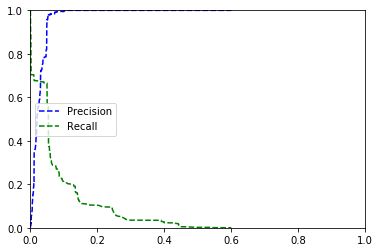

In [21]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

Y_score = clf.predict_proba(X_test)
Y_score = Y_score[:, 1]
Y_score = Y_score.flatten()

precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_score)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.legend(loc="center left")
plt.ylim([0, 1])
plt.xlim([0, 1])

plt.show()

#### Iterate
So our model is far from great, let's see if we can improve it. 
One of the issues we are seeing right now is that despite it's accuracy, it is missing a lot of fraudulent transactions.
A struggle we have is that our dataset is highly imbalanced. We can address this by weighing our inputs

Let's train our model again, but boosting our minority class, is fraudulent

In [17]:
from sklearn.ensemble import RandomForestClassifier

clf_with_weights = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, class_weight="balanced")
clf_with_weights.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [18]:
metrics = clf_with_weights.score(X_test, Y_test)

print(metrics)

0.9462423767601023


Our accuarcy dropped, but let's see if we can outweight that with better recall-precision

In [19]:
from sklearn.metrics import classification_report
target_names = ['non-fraudulent', 'fraudulent']

pred_with_weights = clf_with_weights.predict(X_test)
print(classification_report(Y_test, pred_with_weights, target_names=target_names))

                precision    recall  f1-score   support

non-fraudulent       1.00      0.95      0.97   2096999
    fraudulent       0.02      0.93      0.04      2666

     micro avg       0.95      0.95      0.95   2099665
     macro avg       0.51      0.94      0.51   2099665
  weighted avg       1.00      0.95      0.97   2099665



Wow! We can see that especially recall greatly increased for the fraudulent cases, meaning that we miss a lot less false negatives

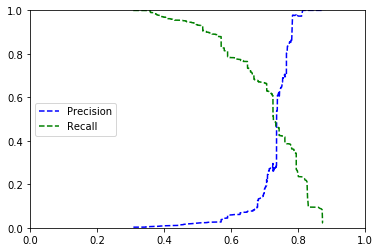

In [20]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

Y_score = clf_with_weights.predict_proba(X_test)
Y_score = Y_score[:, 1]
Y_score = Y_score.flatten()

precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_score)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
plt.legend(loc="center left")
plt.ylim([0, 1])
plt.xlim([0, 1])

plt.show()

#### Confusion matrix
To further explore the ratio between false positives, false negatives, true positives and true negatives, we can have a look at the confusion matrix.
Let's create the confusion matrix for both models

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names =  ['non-fraudulent', 'fraudulent']


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

##### Model 1 (Non-balanced)

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


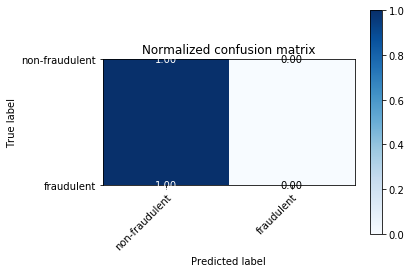

In [30]:
# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

##### Model 2 (Balanced)

Normalized confusion matrix
[[0.95 0.05]
 [0.07 0.93]]


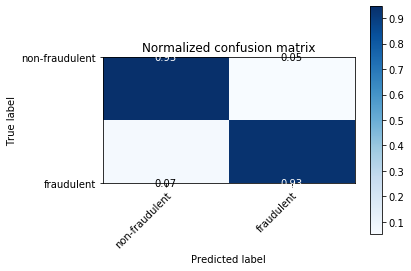

In [27]:
# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, pred_with_weights, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()